In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')


### Import and EDA

In [5]:
climate_train = pd.read_csv('climate_train.csv', 
                            parse_dates=True, index_col=0)
climate_train.head()

,temp,temp_c
date,,
1946-01-01,-34,-3.4
1946-01-02,-30,-3.0
1946-01-03,-28,-2.8
1946-01-04,-27,-2.7
1946-01-05,14,1.4


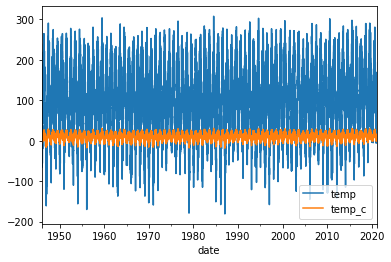

In [6]:
climate_train.plot();

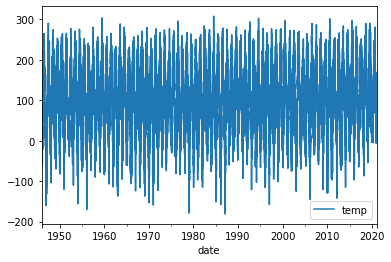

In [7]:
climate_train = climate_train.drop('temp_c',axis=1)
climate_train.plot();

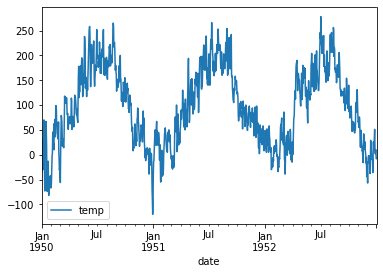

In [8]:
climate_train.loc['1950':'1952'].plot();

In [9]:
climate_train = climate_train.loc['1970-01-01':'2020-12-31']

## Stationary check

In [10]:
test_result=adfuller(climate_train['temp'])

print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])

#This test tests the null hypothesis that a unit root is present 
#in a time series sample. 

#The more negative it is, the stronger the rejection of the hypothesis 
#that there is a unit root at some level of confidence

ADF Statistic: -10.102431
p-value: 0.000000


In [11]:
def adfuller_test(series):
    result=adfuller(series)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis, indicating data is non-stationary")

        
adfuller_test(climate_train['temp'])

ADF Test Statistic : -10.102431377815847
p-value : 1.0509040348286395e-17
#Lags Used : 45
Number of Observations Used : 18582
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


### Resample day -> month

In [12]:
climate_train_monthly = climate_train.resample('1M').mean()

In [15]:
climate_train_monthly.describe()

,temp
count,612.000000
mean,99.994641
std,70.024937
min,-70.516129
25%,41.568817
50%,95.609140
75%,163.944086
max,244.161290


In [16]:
climate_train_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 612 entries, 1970-01-31 to 2020-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    612 non-null    float64
dtypes: float64(1)
memory usage: 9.6 KB


In [13]:
adfuller_test(climate_train_monthly['temp'])

ADF Test Statistic : -4.219775186269357
p-value : 0.0006099137015431435
#Lags Used : 16
Number of Observations Used : 595
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


### SARIMA

In [19]:
auto_arima_model = auto_arima(climate_train_monthly['temp'], start_p=0, start_q=0, max_p=10, max_q=10, max_d=2, 
                              seasonal=True, start_P=0, start_Q=0, max_D=2, m=12, max_P=10, max_Q=10,
                              trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=6940.374, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6201.966, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7619.330, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=6457.891, Time=0.26 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=5464.215, Time=1.24 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=5756.928, Time=0.80 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=2.38 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=6046.915, Time=1.72 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=5626.708, Time=2.79 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=3.15 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=5492.327, Time=0.94 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(0,0,2)(1,0,1)[12] intercept   : AIC=5

In [20]:
sarima_model = SARIMAX(climate_train_monthly['temp'], 
                       order=(0,0,1), seasonal_order=(1,0,1,12)).fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.93009D+01    |proj g|=  2.66233D+01

At iterate    5    f=  5.71703D+00    |proj g|=  9.62105D-02

At iterate   10    f=  5.68292D+00    |proj g|=  1.38118D-02

At iterate   15    f=  5.40228D+00    |proj g|=  5.92287D-02

At iterate   20    f=  4.55510D+00    |proj g|=  7.18523D-02

At iterate   25    f=  4.45262D+00    |proj g|=  1.18864D-03

At iterate   30    f=  4.45259D+00    |proj g|=  2.69386D-04

At iterate   35    f=  4.45259D+00    |proj g|=  2.62734D-04

At iterate   40    f=  4.45259D+00    |proj g|=  6.25486D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

In [22]:
rmse_sarima = np.sqrt(mean_squared_error(climate_train_monthly['temp'], 
                                         sarima_model.predict()))
rmse_sarima

24.035330958929578

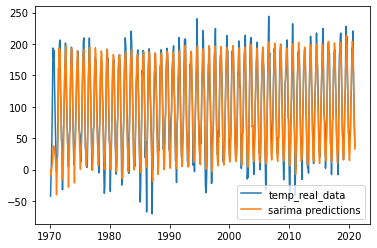

In [23]:
plt.plot(climate_train_monthly['temp'], label='temp_real_data')
plt.plot(sarima_model.predict(), label='sarima predictions')
plt.legend()

plt.show()

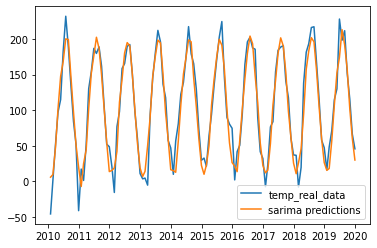

In [25]:
plt.plot(climate_train_monthly['temp'].loc['2010':'2019'], label='temp_real_data')
plt.plot(sarima_model.predict().loc['2010':'2019'], label='sarima predictions')
plt.legend()

plt.show()

In [27]:
rmse_sarima_last20y = np.sqrt(mean_squared_error(climate_train_monthly['temp'].loc['2000':'2019'],
                                                sarima_model.predict().loc['2000':'2019']))
rmse_sarima_last20y

19.63830782199094

## Test

In [28]:
climate_test = pd.read_csv('climate_test.csv', parse_dates=True, index_col=0)

In [33]:
climate_test = climate_test.drop('temp_c', axis=1)

In [34]:
climate_test_monthly = climate_test.resample('1M').mean()

In [35]:
climate_test_monthly

,temp
date,
2021-01-31,11.709677
2021-02-28,10.607143
2021-03-31,52.612903
2021-04-30,69.300000
2021-05-31,125.483871
2021-06-30,216.333333
2021-07-31,212.064516
2021-08-31,180.548387
2021-09-30,162.766667


In [37]:
climate_test_monthly['sarima_predictions'] = sarima_model.predict(start='2021-01-31', end='2021-12-31')

In [38]:
climate_test_monthly

,temp,sarima_predictions
date,,
2021-01-31,11.709677,15.049563
2021-02-28,10.607143,24.010639
2021-03-31,52.612903,52.788498
2021-04-30,69.300000,105.197150
2021-05-31,125.483871,146.907495
2021-06-30,216.333333,184.386853
2021-07-31,212.064516,199.520965
2021-08-31,180.548387,198.580622
2021-09-30,162.766667,153.870699


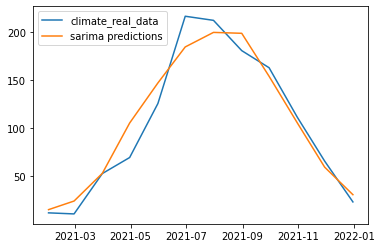

In [40]:
plt.plot(climate_test_monthly['temp'], label='climate_real_data')
plt.plot(climate_test_monthly['sarima_predictions'], label='sarima predictions')
plt.legend()

plt.show()

In [47]:
rmse_sarima_2021 = np.sqrt(mean_squared_error(climate_test_monthly['temp'],
                                                climate_test_monthly['sarima_predictions']))

In [48]:
rmse_sarima_2021

17.444235909785426

In [49]:
from sklearn.metrics import r2_score
r2_score(climate_test_monthly['temp'], climate_test_monthly['sarima_predictions'])

0.942245792274459